In [3]:
def collate_fn(batch):
        # Convert the batch of images and annotations to tensors
        images = []
        annotations = []
        for img, annotation in batch:
            images.append(img)
            annotations.append(annotation)
        images = torch.stack(images, dim=0)
        return images, annotations

In [4]:
from src.data.dataloader import *
import torchvision.datasets as datasets

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Instantiate the dataset and dataloader
dataset_train = TacoDataset(dataset_path = r'/work3/s212725/WasteProject/data', split_type = 'train', transform=None)
taco_dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)

dataset_test = TacoDataset(dataset_path = r'/work3/s212725/WasteProject/data', split_type = 'test', transform=transform)
taco_dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn=collate_fn)

dataset_val = TacoDataset(dataset_path = r'/work3/s212725/WasteProject/data', split_type = 'val', transform=transform)
taco_dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=True, collate_fn=collate_fn)

Reading annotations file: /work3/s212725/WasteProject/data/annotations_0_train.json
Reading annotations file: /work3/s212725/WasteProject/data/annotations_0_test.json
Reading annotations file: /work3/s212725/WasteProject/data/annotations_0_val.json


In [47]:
image, anns = dataset_train[0]

In [35]:
print(image.shape)

torch.Size([3, 256, 256])


In [62]:
anns['boxes']
anns['supercats']
anns['image_id'].item()

377

# Get image with bbox, crop bbox and store with label

<PIL.Image.Image image mode=RGB size=3024x4032 at 0x7F3C8776BA00>
/work3/s212725/WasteProject/data/batch_14/000077.jpg
Bottle
Bottle cap


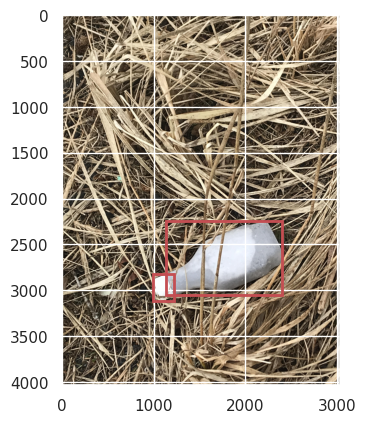

In [9]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ExifTags
import matplotlib.patches as patches

fig, ax = plt.subplots()

image, anns = dataset_train[3]
print(image)

# Display the image
image = np.asarray(image)
ax.imshow(image)

print(anns['image_path'])
for i in range(len(anns['boxes'])):
    cat = anns['supercats'][i]
    print(cat)
    x = int(anns['boxes'][i][0])
    y = int(anns['boxes'][i][1])
    width = int(anns['boxes'][i][2])
    height = int(anns['boxes'][i][3])

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the axes
    ax.add_patch(rect)
plt.show()

### Bounding boxes after resizing

In [6]:
def resize_image(image_path):
    with Image.open(image_path) as image:
        # Get original size
        width, height = image.size

        # Determine which dimension to resize based on maximum dimension
        if width > height and width > 480:
            ratio = 480.0 / width
            new_size = (int(width * ratio), int(height * ratio))
        elif height > width and height > 480:
            ratio = 480.0 / height
            new_size = (int(width * ratio), int(height * ratio))
        else:
            ratio = 1
            return image, ratio

        # Resize image with new size and preserve aspect ratio
        resized_image = image.resize(new_size, Image.ANTIALIAS)

        return resized_image, ratio

In [ ]:
resized_image, ratio = resize_image(image_path)
image = np.array(resized_image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [101]:
anns['boxes']

tensor([[1737., 1019., 1411.,  781.]])

# Image Crop

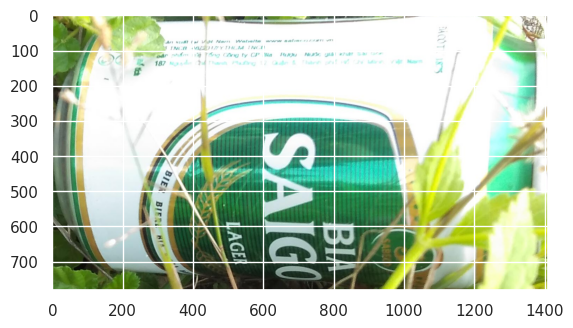

In [58]:
# Crop the image
crop_left = x
crop_top = y
crop_right = x + width
crop_bottom = y + height
ground_truth = image.crop((crop_left, crop_top, crop_right, crop_bottom))

# Display the cropped image
fig, ax = plt.subplots()
ax.imshow(image_crop)
plt.show()

# Run selective search in the image and compare the new crops with the gt

In [111]:
from PIL import Image

def resize_image(image_path):
    with Image.open(image_path) as image:
        # Get original size
        width, height = image.size

        # Determine which dimension to resize based on maximum dimension
        if width > height and width > 480:
            ratio = 480.0 / width
            new_size = (int(width * ratio), int(height * ratio))
        elif height > width and height > 480:
            ratio = 480.0 / height
            new_size = (int(width * ratio), int(height * ratio))
        else:
            ratio = 1
            return image, ratio

        # Resize image with new size and preserve aspect ratio
        resized_image = image.resize(new_size, Image.ANTIALIAS)

        return resized_image, ratio

Reading annotations file: /work3/s212725/WasteProject/data/annotations.json
The image has been resized to shape: (480, 360)


/tmp/ipykernel_23288/1347512576.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(new_size, Image.ANTIALIAS)
/zhome/7a/d/164695/venvs/P1_classification_dlcv/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/zhome/7a/d/164695/venvs/P1_classification_dlcv/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/zhome/7a/d/164695/venvs/P1_classification_

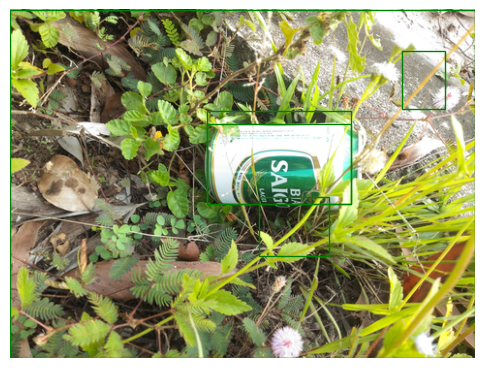

In [125]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import selective_search
import matplotlib.patches as mpatches

dataset_path = r'/work3/s212725/WasteProject/data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    print('Reading annotations file: ' + anns_file_path)
    annotations = json.load(f)
    images = annotations['images']
    
file_name = images[anns['image_id'].item()]['file_name']
image_path = dataset_path + '/' + file_name
fig, ax = plt.subplots(figsize=(6, 6))
resized_image, ratio = resize_image(image_path)
ax.imshow(resized_image)
print(f"The image has been resized to shape: {resized_image.size}" )
image = np.array(resized_image)
# Propose boxes using selective search
boxes = selective_search.selective_search(image, mode='fast')
boxes_filter = selective_search.box_filter(boxes, min_size=1, topN=5)
# drawing rectangles on the original image

for x1, y1, x2, y2 in boxes_filter:
    bbox = mpatches.Rectangle(
        (x1, y1), (x2-x1), (y2-y1), fill=False, edgecolor='green', linewidth=1)
    ax.add_patch(bbox)
plt.axis('off')
plt.show()
    

### Transforming coordinates to resized image

In [116]:
image, anns = dataset_train[0]
for i in range(len(anns['boxes'])):
    print(from_tensor_to_tuple(anns['boxes'][i]))
    
tuplee = from_tensor_to_tuple(anns['boxes'][i])
result = tuple(ratio * x for x in tuplee)

print(ratio)

(1737, 1019, 3148, 1800)
(200.42307692307693, 117.57692307692308, 363.2307692307692, 207.6923076923077)
0.11538461538461539


# Covert array to tuple

In [83]:
import torch

def from_tensor_to_tuple(bbox_tensor):
    # convert to tuple
    x_min, y_min, width, height = bbox_tensor.tolist()
    x_max, y_max = x_min + width, y_min + height
    bbox_tuple = (int(x_min), int(y_min), int(x_max), int(y_max))
    return bbox_tuple

In [97]:
boxes_filter

[(0, 0, 480, 360),
 (203, 105, 351, 201),
 (404, 43, 449, 102),
 (257, 193, 329, 254),
 (203, 118, 351, 201)]

In [94]:
def calculate_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth rectangles
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    # return the intersection over union value
    return iou

In [107]:
gt2 = from_tensor_to_tuple(anns['boxes'][0])
print(gt2)

(1737, 1019, 3148, 1800)


In [118]:
classes = {'Background':28 , 'Aluminium foil': 0, 'Battery': 1, 'Blister pack': 2, 'Bottle': 3, 'Bottle cap': 4, 
        'Broken glass': 5, 'Can': 6, 'Carton': 7, 'Cup': 8, 'Food waste': 9, 'Glass jar': 10, 
        'Lid': 11, 'Other plastic': 12, 'Paper': 13, 'Paper bag': 14, 'Plastic bag & wrapper': 15,
        'Plastic container': 16, 'Plastic glooves': 17, 'Plastic utensils': 18, 'Pop tab': 19,
        'Rope & strings': 20, 'Scrap metal': 21, 'Shoe': 22, 'Squeezable tube': 23, 'Straw': 24,
        'Styrofoam piece': 25, 'Unlabeled litter': 26, 'Cigarette': 27}
        

In [120]:
super_cats = anns['supercats']
print(super_cats)

['Can']


In [123]:
crops_with_labels = {}
for i in range(len(anns['boxes'])):
    for j in range(len(boxes_filter)):
        # compare intersection over union
        gt = from_tensor_to_tuple(anns['boxes'][i])
        gt_resized = tuple(ratio * x for x in gt)
        cat_gt = super_cats[i]
        crop = boxes_filter[j]
        print(calculate_iou(gt_resized, crop))
        iou = calculate_iou(gt_resized, crop)
        if iou < 0.5:
            crops_with_labels[crop] = classes['Background']
        else:
            crops_with_labels[crop] = classes[cat_gt]
        

0.08595551101165028
0.748780706227492
0.0
0.06257768330593487
0.8385704407055561


In [124]:
crops_with_labels

{(0, 0, 480, 360): 28,
 (203, 105, 351, 201): 6,
 (404, 43, 449, 102): 28,
 (257, 193, 329, 254): 28,
 (203, 118, 351, 201): 6}

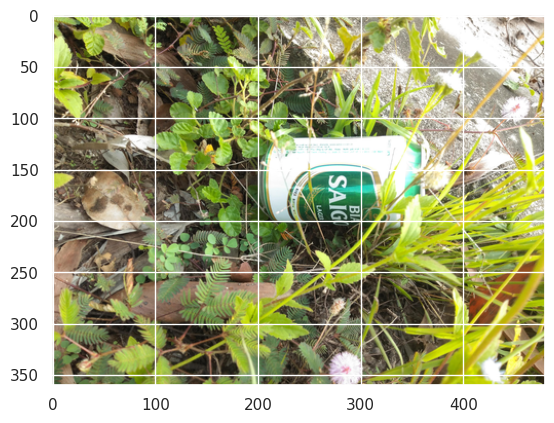

In [72]:
x = boxes_filter[0][0]
y = boxes_filter[0][1]
width = boxes_filter[0][2]
height = boxes_filter[0][3]
crop_left = x
crop_top = y
crop_right = x + width
crop_bottom = y + height
image_crop = resized_image.crop((crop_left, crop_top, crop_right, crop_bottom))

# Display the cropped image
fig, ax = plt.subplots()
ax.imshow(image_crop)
plt.show()